In [1]:
import pickle
import pandas as pd
import warnings
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import optimize
import pickle
import statsmodels.api as sm
from scipy import stats

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
file_path = f'monthly_data/regression_data.pkl'
with open(file_path, 'rb') as file:
    flow=pickle.load(file)

In [3]:
flow

,Zips,2020_01,2022_01,2020_02,2022_02,2020_03,2022_03,2020_04,2022_04,2020_05,...,2020_08,2022_08,2020_09,2022_09,2020_10,2022_10,2020_11,2022_11,2020_12,2022_12
0,91405,129.982779,0.000000,178.443909,0,156.263772,0.0,90.756919,175.322709,86.284277,...,0,142.661362,0,145.779707,143.839915,197.782065,141.882348,199.399547,131.220538,164.758239
1,91401,139.107103,0.000000,189.231009,0,164.334335,0.0,92.905987,202.364708,88.626650,...,0,165.737387,0,155.121469,157.087497,235.327630,152.309292,231.970098,141.513462,200.611920
2,91402,174.760222,0.000000,223.134552,0,213.705532,0.0,140.449469,227.674508,130.499213,...,0,200.930970,0,181.821877,190.478402,258.337127,187.255434,262.442782,174.931811,234.013459
3,91605,139.635252,0.995261,184.639989,0,164.911861,0.0,100.790765,179.907723,101.333942,...,0,142.046943,0,135.347245,177.099141,212.036234,165.821314,218.133060,147.094950,188.350562
4,91331,126.797529,0.000000,159.963105,0,157.884212,0.0,103.354097,181.613320,97.990752,...,0,156.981598,0,143.517929,144.327235,206.011202,143.379136,210.856508,131.315111,188.622084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,13359,0.000000,1.493192,0.000000,0,0.000000,0.0,0.000000,157.520507,0.000000,...,0,119.836033,0,124.785419,0.000000,181.448094,0.000000,178.990854,0.000000,165.482951
163,90074,0.000000,0.000000,0.000000,0,0.000000,0.0,0.000000,126.346240,0.000000,...,0,110.614066,0,109.675211,0.000000,145.692026,0.000000,158.803196,0.000000,132.663538
164,90290,0.000000,0.000000,0.000000,0,0.000000,0.0,0.000000,123.281880,0.000000,...,0,95.203024,0,113.658797,0.000000,197.988931,0.000000,197.083797,0.000000,178.837250
165,90202,0.000000,0.000000,0.000000,0,0.000000,0.0,0.000000,60.796255,0.000000,...,0,56.499318,0,69.493186,0.000000,133.577730,0.000000,119.634181,0.000000,107.251762


In [4]:
#select 4,5,6,10,11,12
df = flow[['Zips','2020_04','2020_05','2020_06','2020_10','2020_11','2020_12','2022_04','2022_05','2022_06','2022_10','2022_11','2022_12']]
df=df[(df!=0).all(axis=1)]
diff_in_diff_local = {}
for i in df.index:
    lock_2020 = (df['2020_04'][i]+df['2020_05'][i]+df['2020_06'][i])/3
    post_2020 = (df['2020_10'][i]+df['2020_11'][i]+df['2020_12'][i])/3
    lock_2022 = (df['2022_04'][i]+df['2022_05'][i]+df['2022_06'][i])/3
    post_2022 = (df['2022_10'][i]+df['2022_11'][i]+df['2022_12'][i])/3
    value = (df['2022_04'][i])#-(lock_2022-post_2022)
    diff_in_diff_local[df['Zips'][i]] = value

In [5]:
censusdata = pickle.load( open( "diff_in_diff.p", "rb" ) )

In [6]:
len(set([str(i) for i in censusdata.zipcode.values]).intersection(set(df.Zips.values)))
#88 zipcodes are overlapped

88

In [7]:
censusdata

,zipcode,int1_2019,int2_2019,int3_2019,int4_2019,int1_2020,int2_2020,int3_2020,int4_2020,total,...,industry_12,industry_13,num_cars,diff1,diff2,diff3,diff4,diverse index,stable,diff_in_diff
0,91302,1.0,0.964655,178.509029,153.534878,1.039839,1.258441,289.934299,256.969282,26961.0,...,0.020,0.007,23082,-0.039839,-0.304550,-0.624200,-0.673687,0.371539,1,0.253947
1,90081,1.0,1.061654,208.606087,208.242668,1.165239,0.765542,188.217464,174.438031,NaN,...,NaN,NaN,46,-0.165239,0.278916,0.097737,0.162333,NaN,1,-0.461352
2,90022,1.0,1.114941,290.312798,278.805563,1.325561,0.990883,275.803424,255.592497,66168.0,...,0.050,0.033,42347,-0.325561,0.111269,0.049978,0.083259,0.077937,1,-0.449619
3,91754,1.0,1.158260,179.182143,122.168014,0.924705,0.451420,96.717009,89.887527,33343.0,...,0.051,0.048,26781,0.075295,0.610261,0.460231,0.264230,0.524533,1,-0.631546
4,91803,1.0,1.051115,169.587362,144.390786,1.072864,0.724259,141.648980,130.191937,30093.0,...,0.054,0.069,23535,-0.072864,0.310962,0.164743,0.098336,0.591551,1,-0.399721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,91312,1.0,1.088705,165.407148,143.783374,1.073354,0.823157,138.957907,134.458675,NaN,...,NaN,NaN,3,-0.073354,0.243912,0.159904,0.064852,NaN,1,-0.338902
215,91326,1.0,1.050365,121.357683,110.829104,1.011052,0.675520,92.511048,115.207322,36126.0,...,0.047,0.048,30323,-0.011052,0.356871,0.237699,-0.039504,0.700425,1,-0.385897
216,91361,1.0,0.900041,160.307107,144.757900,0.998872,0.667419,147.119061,154.095239,19953.0,...,0.027,0.020,18914,0.001128,0.258457,0.082267,-0.064503,0.360755,1,-0.231494
217,90670,1.0,0.943013,206.684383,201.427176,0.946471,0.790467,201.219890,190.069540,16410.0,...,0.039,0.057,20905,0.053529,0.161765,0.026439,0.056386,0.430550,1,-0.099018


In [8]:
new_diff = []
for i in censusdata.index:
    if str(censusdata['zipcode'][i]) in diff_in_diff_local:
        new_diff.append(diff_in_diff_local[str(censusdata['zipcode'][i])])
    else:
        new_diff.append(0)
new_diff = pd.Series(new_diff,index=censusdata.index)
censusdata['new_diff'] = new_diff
censusdata=censusdata[censusdata['new_diff']!=0]

In [9]:
censusdata=censusdata.dropna()

In [10]:
censusdata

,zipcode,int1_2019,int2_2019,int3_2019,int4_2019,int1_2020,int2_2020,int3_2020,int4_2020,total,...,industry_13,num_cars,diff1,diff2,diff3,diff4,diverse index,stable,diff_in_diff,new_diff
4,91803,1.0,1.051115,169.587362,144.390786,1.072864,0.724259,141.648980,130.191937,30093.0,...,0.069,23535,-0.072864,0.310962,0.164743,0.098336,0.591551,1,-0.399721,372.812706
11,90023,1.0,1.002597,335.358998,310.251052,0.953115,0.639527,283.469489,257.874742,46517.0,...,0.036,28545,0.046885,0.362130,0.154728,0.168819,0.072885,1,-0.316186,111.561056
12,90230,1.0,1.005279,191.466114,185.861696,0.945038,0.564788,171.334681,160.941943,33135.0,...,0.032,23969,0.054962,0.438178,0.105144,0.134077,0.720207,1,-0.385529,179.857835
14,90026,1.0,0.973244,236.896074,209.306833,0.905527,1.232647,310.336200,181.074228,67657.0,...,0.029,38021,0.094473,-0.266534,-0.310010,0.134886,0.643577,1,0.353875,171.315777
16,90041,1.0,0.981632,178.200528,160.335448,0.996742,0.575720,150.268546,151.323682,29888.0,...,0.046,19236,0.003258,0.413508,0.156745,0.056206,0.713533,1,-0.402655,88.734552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,90029,1.0,0.873290,212.508916,202.266398,0.937985,0.657117,198.590739,172.737905,36126.0,...,0.020,19217,0.062015,0.247539,0.065495,0.145988,0.627600,1,-0.154158,196.915490
209,90064,1.0,1.043418,234.832384,209.613801,0.972180,0.619813,214.990277,213.989962,25988.0,...,0.021,21282,0.027820,0.405978,0.084495,-0.020877,0.601390,1,-0.395785,219.988090
210,90042,1.0,1.035768,138.850715,131.813002,1.179548,0.589504,103.140850,114.942108,60509.0,...,0.030,39534,-0.179548,0.430853,0.257182,0.127991,0.580232,1,-0.625812,89.751492
215,91326,1.0,1.050365,121.357683,110.829104,1.011052,0.675520,92.511048,115.207322,36126.0,...,0.048,30323,-0.011052,0.356871,0.237699,-0.039504,0.700425,1,-0.385897,149.940516


In [11]:
data1p = [i for i in censusdata['total']]
data1e = [i for i in censusdata['employed_ratio']]
data1i = [i for i in censusdata['median income (dollars)']]
data1w = [i for i in censusdata['hispanic_ratio']]
data1b = [i for i in censusdata['black_ratio']]
data1a = [i for i in censusdata['asian_ratio']]
data1h = [i for i in censusdata['other_ratio']]
data1d = [i for i in censusdata['population density']]
data1di = [i for i in censusdata['diverse index']]
'''
data1c1 = [i for i in censusdata['commuting_drove_alone']]
data1c2 = [i for i in censusdata['commuting_carpool']]
data1c3 = [i for i in censusdata['commuting_public']]
data1c4 = [i for i in censusdata['commuting_walked']]
data1c5 = [i for i in censusdata['commuting_at_home']]
data1c6 = [i for i in censusdata['commuting_time']]

data1cl1 = [i for i in censusdata['class_private_wage']]
data1cl2 = [i for i in censusdata['class_government']]
data1cl3 = [i for i in censusdata['class_self']]

data1car = [i for i in censusdata['num_cars']]
'''

data1traffic = np.array([i for i in censusdata['new_diff']])

#train = np.array([data1p,data1e,data1i,data1w,data1b,data1a,data1h,data1d,data1di,
#                  data1c1,data1c2,data1c3,data1c4,data1c5,data1c6,
#                  data1cl1,data1cl2,data1cl3,data1car]).T 
train = np.array([data1p,data1e,data1i,data1w,data1b,data1a,data1h,data1d,data1di]).T 

train = sm.add_constant(train)
lr1 = sm.OLS(data1traffic ,train).fit()

#lr1.summary(xname=['const','total population', 'employment ratio','median income', 'hispanic proportion', 'black proportion', 'asian proportion', 'other proportion','population density','diverse index','drove alone','carpool','public','walked','at home','time','private wage','government','self','cars'])
lr1.summary(xname=['const','total population', 'employment ratio','median income', 'hispanic proportion', 'black proportion', 'asian proportion', 'other proportion','population density','diverse index'])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                 -0.049
Method:                 Least Squares   F-statistic:                    0.5917
Date:                Fri, 15 Sep 2023   Prob (F-statistic):              0.800
Time:                        10:23:25   Log-Likelihood:                -416.42
No. Observations:                  79   AIC:                             852.8
Df Residuals:                      69   BIC:                             876.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -88.1055    330.441     -0.267      0.791    -747.318     571.106
total population        0.0002      0.000      0.640      0.524      -0.000       0.001
employment ratio      328.1871    381.374      0.861      0.392    -432.634    1089.008
median income          -0.0003      0.000     -0.617      0.539      -0.001       0.001
hispanic proportion   -61.2041     54.900     -1.115      0.269    -170.726      48.318
black proportion       94.0625     75.049      1.253      0.214     -55.657     243.782
asian proportion       48.4080     71.152      0.680      0.499     -93.537     190.353
other proportion     -223.6356    551.212     -0.406      0.686   -1323.274     876.002
population density  -6.594e-05      0.001     -0.062      0.951      -0.002       0.002
diverse index         -23.3475     67.196     -0.347      0.729    -157.399     110.704
==============================================================================
Omnibus:                       25.861   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.436
Skew:                           1.228   Prob(JB):                     8.25e-11
Kurtosis:                       5.842   Cond. No.                     8.45e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

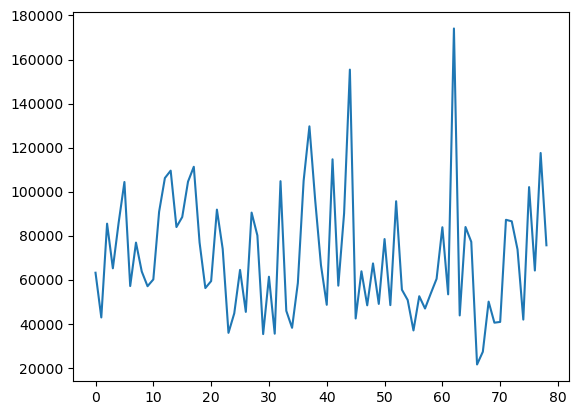

In [12]:
plt.plot(data1i)